In [1]:
import pickle
import gzip
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import keras
import sklearn
import tensorflow as tf
from tqdm import tqdm_notebook
%matplotlib inline

Using TensorFlow backend.


In [2]:
filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()

In [3]:
train_x, train_y = training_data
val_x, val_y = validation_data
test_x, test_y = test_data

In [4]:
imgs = os.listdir("USPSTestSet")
USPS_Test_Imgs = []
digit=[]
for img in imgs:
    img_path = "USPSTestSet/" + img
    if img[-3:]=='png':
        img = Image.open(img_path,'r')
        img = img.resize((28,28))
        digit=img
        img = (255-np.array(img.getdata())) / 255
        USPS_Test_Imgs.append(img)
USPS_Test_Imgs = np.array(USPS_Test_Imgs)
USPS_Test_Imgs.shape   

(1500, 784)

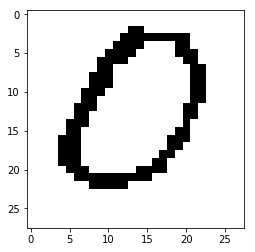

In [5]:
plt.imshow(digit)

In [6]:
USPS_test_label = []
for i in range(9,-1,-1):
   USPS_test_label +=  [i]*150
USPS_test_label = np.array(USPS_test_label)

In [7]:
USPS_test_label.shape

(1500,)

In [8]:
# Add bias in all samples of MNIST and USPS dataset

train_x=np.concatenate((np.ones((train_x.shape[0],1)),train_x),axis=1)
val_x=np.concatenate((np.ones((val_x.shape[0],1)),val_x),axis=1)
test_x = np.concatenate((np.ones((test_x.shape[0],1)),test_x),axis=1) 
USPS_Test_Imgs =np.concatenate((np.ones((USPS_Test_Imgs.shape[0],1)),USPS_Test_Imgs),axis=1)

In [9]:
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)
print(USPS_Test_Imgs.shape)

(50000, 785)
(10000, 785)
(10000, 785)
(1500, 785)


In [10]:
one_hot_train_y = keras.utils.to_categorical(train_y)
one_hot_val_y = keras.utils.to_categorical(val_y)
one_hot_test_y = keras.utils.to_categorical(test_y)
one_hot_USPS_test_label = keras.utils.to_categorical(USPS_test_label)

In [11]:
print(one_hot_train_y.shape)
print(one_hot_val_y.shape)
print(one_hot_test_y.shape)
print(one_hot_USPS_test_label.shape)

(50000, 10)
(10000, 10)
(10000, 10)
(1500, 10)


In [12]:
def softmaxFunction(inputData, weight):
    intmdTerm = np.exp(np.matmul(inputData, weight) - np.max(np.matmul(inputData, weight)))
    softmax = (intmdTerm.T / np.sum(intmdTerm,axis=1)).T
    return softmax

In [13]:
def cross_entropy(m,data,weight,Target):
    J = (-1/m)*np.sum(Target * np.log(softmaxFunction(data,weight)))
    return J

In [14]:
def gd(m,weight,X, Target, Learningrate,iterations): # gd stands for Gradient Descent
    cost_functionList = [0]* iterations
    for i in tqdm_notebook(range(iterations)):
        weight = weight - (Learningrate/m) * np.dot( X.T, (softmaxFunction(X,weight) - Target))
        cost = cross_entropy(m,X,weight,Target)
        cost_functionList[i] = cost
    return weight, cost_functionList

In [15]:
weight = np.zeros((train_x.shape[1],one_hot_test_y.shape[1]))
numOftraining_examples,numOfvalidation_examples,numOftest_examples, numOfUSPS_Test_examples = len(train_x), len(val_x), len(test_x), len(USPS_Test_Imgs)
Learningrate = 0.15
iterations = 300
batch_size = 128
New_weight, costList = gd(numOftraining_examples,weight,train_x,one_hot_train_y,Learningrate,iterations)

Text(0.5, 1.0, 'Cost Vs. Number of iterations')

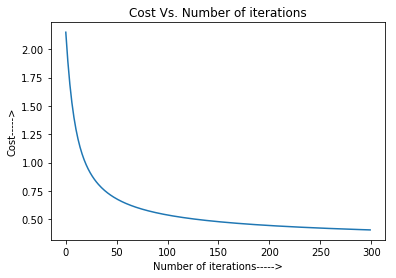

In [51]:
plt.plot([i for i in range(iterations)],costList)
plt.xlabel("Number of iterations----->")
plt.ylabel("Cost----->")
plt.title("Cost Vs. Number of iterations")

In [17]:
def mini_batch_sgd(m,weight,X, Target, Learningrate,epochs,batchSize):
    cost_functionList = [0]* epochs
    for epoch in tqdm_notebook(range(epochs)):
        arbit = np.random.permutation(m)
        X = X[arbit]
        Target = Target[arbit]
        cost = 0
        for i in tqdm_notebook(range(0,m,batchSize)):
            X_mini = X[i:i+batchSize]
            Target_mini = Target[i:i+batchSize]
            weight = weight - (Learningrate/m) * np.dot( X_mini.T, (softmaxFunction(X_mini,weight) - Target_mini))
            cost += cross_entropy(m,X,weight,Target)
        cost_functionList[epoch] = cost
    return weight,cost_functionList

In [ ]:
Weight_now,Cost_list = mini_batch_sgd(numOftraining_examples, weight, train_x, one_hot_train_y, Learningrate, iterations, batch_size)

In [ ]:
plt.plot([i for i in range(iterations)],Cost_List,'b.')

In [17]:
def predictions(Input,weight):
    preds = softmaxFunction(Input,weight)
    preds = np.argmax(preds,axis=1)
    return preds

In [18]:
def getAccuracy(Input,Target):
    preds = predictions(Input,New_weight) # Use New_weight for Bgd
    accuracy = sum(preds == Target)/(float(len(Target)))
    return accuracy

In [19]:
print("Validation Accuracy = ",getAccuracy(val_x,val_y))
print("Test Accuracy = ",getAccuracy(test_x,test_y))

Validation Accuracy =  0.9042
Test Accuracy =  0.9003


In [20]:
# For USPS test set

print(getAccuracy(USPS_Test_Imgs,USPS_test_label))

0.318


In [21]:
predict = predictions(test_x,New_weight)
actualOutput = test_y
print(actualOutput,"\n\n",predict)

[7 2 1 ... 4 5 6] 

 [7 2 1 ... 4 5 6]


In [22]:
df =pd.DataFrame(test_y,columns=['Actual_label'])
df.head()

,Actual_label
0,7
1,2
2,1
3,0
4,4


In [23]:
classified_counts = {}
misclassified_counts ={}

def classificationReport(actual_label, predicted_label):
    for true,pred in list(zip(actual_label, predicted_label)):
        if pred == true:
            if pred in classified_counts:
                classified_counts[pred] = classified_counts[pred]+1
            else:
                classified_counts[pred]=1
        else:
            if pred in misclassified_counts:
                misclassified_counts[pred] = misclassified_counts[pred]+1
            else:
                misclassified_counts[pred]=1
    return classified_counts, misclassified_counts

In [24]:
correctCounts, misclassifiedCounts = classificationReport(test_y, predict)
TotalCounts = dict(df['Actual_label'].value_counts())

In [25]:
print("Report:\n")
print(" "*5 + "labels"," "*5 + "precision"," "*5 + "recall" , " "*5 + "f1-score")

for i in range(len(TotalCounts)):
    precision = correctCounts[i]/(correctCounts[i]+misclassifiedCounts[i])
    recall = correctCounts[i]/ TotalCounts[i]
    f1_score = (2 * precision * recall) / (precision + recall)
    print(" "*8,i," "*8,format(precision,".2f")," "*8,format(recall,".2f")," "*8,format(f1_score,".2f"))

Report:

     labels      precision      recall      f1-score
         0          0.93          0.98          0.95
         1          0.95          0.97          0.96
         2          0.91          0.86          0.88
         3          0.88          0.89          0.89
         4          0.89          0.91          0.90
         5          0.89          0.82          0.85
         6          0.92          0.93          0.93
         7          0.91          0.89          0.90
         8          0.85          0.86          0.85
         9          0.86          0.87          0.87


In [26]:
# Confusion Matrix from sklearn to validate our report's output

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report 
print("Confusion matrix:\n\n",confusion_matrix(test_y,predict))
print("\naccuracy :\n",accuracy_score(test_y,predict))
print("\nreport :\n",classification_report(test_y,predict))

Confusion matrix:

 [[ 957    0    3    3    0    1    8    1    7    0]
 [   0 1103    2    4    1    2    4    0   19    0]
 [  13    6  887   19   16    0   18   22   42    9]
 [   6    1   17  898    1   31    6   16   22   12]
 [   2    6    5    0  898    1   10    2    8   50]
 [  14    6    6   43   15  733   17   10   37   11]
 [  16    3    7    2   13   16  895    1    5    0]
 [   3   20   29    4   11    0    0  916    4   41]
 [   9   10   10   31    8   27   13   14  835   17]
 [  13    8    7   11   45   16    0   22    6  881]]

accuracy :
 0.9003

report :
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.95      0.97      0.96      1135
           2       0.91      0.86      0.88      1032
           3       0.88      0.89      0.89      1010
           4       0.89      0.91      0.90       982
           5       0.89      0.82      0.85       892
           6       0.92      0.93      

In [27]:
from keras.models import Sequential
from keras.layers import Dense

In [28]:
# Initialising the ANN

clf_1 = Sequential()

In [29]:
# Adding the input layer and the first hidden layer

clf_1.add(Dense(units=64,activation="relu", input_shape=(train_x[:,1:].shape[1],)))

# Adding the output layer

clf_1.add(Dense(units=one_hot_train_y.shape[1], activation= "softmax"))
clf_1.compile(optimizer='sgd',loss= 'categorical_crossentropy',metrics=['accuracy'])
history = clf_1.fit(train_x[:,1:],one_hot_train_y,batch_size=128,epochs=150,verbose=False)

In [30]:
loss_val, accuracy_val = clf_1.evaluate(val_x[:,1:],one_hot_val_y)
loss_test, accuracy_test = clf_1.evaluate(test_x[:,1:],one_hot_test_y)

10000/10000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 33us/step


In [31]:
print("loss for validation MNIST set :",loss_val)
print("Accuracy for validation MNIST set is ",accuracy_val)
print("\nloss for MNIST test set :",loss_test)
print("Accuracy for MNIST test set is ",accuracy_test)

loss for validation MNIST set : 0.1066227954145521
Accuracy for validation MNIST set is  0.9699

loss for MNIST test set : 0.10766367815323175
Accuracy for MNIST test set is  0.9678


In [32]:
# For USPS set

loss, accuracy = clf_1.evaluate(USPS_Test_Imgs[:,1:],one_hot_USPS_test_label)


1500/1500 [==============================] - ETA:  - ETA:  - 0s 57us/step


In [33]:
print("loss for USPS :",loss)
print("Accuracy for USPS is ",accuracy)

loss for USPS : 2.750662892023722
Accuracy for USPS is  0.4180000000397364


In [34]:
from sklearn.svm import SVC

In [35]:
# Support vector machine classifier

clf_2 = SVC(kernel='linear', C=2, gamma = 0.05)
clf_2.fit(train_x[:,1:], train_y)

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [36]:
print("accuracy :",accuracy_score(val_y,clf_2.predict(val_x[:,1:])))

accuracy : 0.9377


In [37]:
result = clf_2.predict(test_x[:,1:])

In [38]:
# Confusion Matrix for SVM

print("Confusion matrix:\n\n",confusion_matrix(test_y,result))
print("\naccuracy :\n",accuracy_score(test_y,result))
print("\nreport :\n",classification_report(test_y,result))

Confusion matrix:

 [[ 958    0    5    1    1    3    8    1    1    2]
 [   0 1117    4    4    0    1    2    1    6    0]
 [   6   11  960   13    3    1   12   10   14    2]
 [   4    2   19  944    3   13    1    7   14    3]
 [   2    1    9    0  944    0    5    1    2   18]
 [  15    7    4   39    5  787   11    1   19    4]
 [  10    3   11    1    5   13  912    1    2    0]
 [   0   10   20   10    5    2    0  960    4   17]
 [  11    6    7   24   10   22    8    9  869    8]
 [   7    7    2   13   33    3    0   22    9  913]]

accuracy :
 0.9364

report :
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.93      0.93      1032
           3       0.90      0.93      0.92      1010
           4       0.94      0.96      0.95       982
           5       0.93      0.88      0.91       892
           6       0.95      0.95      

In [39]:
# Using rbf kernel
clf_2_ = SVC(kernel='rbf', C=1, gamma = 0.05)
clf_2_.fit(train_x[:,1:], train_y)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [40]:
print("accuracy :",accuracy_score(val_y,clf_2_.predict(val_x[:,1:])))

accuracy : 0.9821


In [41]:
result_ = clf_2_.predict(test_x[:,1:])


In [42]:
# Confusion Matrix for SVM

print("Confusion matrix:\n\n",confusion_matrix(test_y,result_))
print("\naccuracy :\n",accuracy_score(test_y,result_))
print("\nreport :\n",classification_report(test_y,result_))

Confusion matrix:

 [[ 972    0    1    0    0    2    2    1    2    0]
 [   0 1127    3    1    0    1    0    1    2    0]
 [   4    0 1015    1    1    0    0    6    5    0]
 [   0    0    1  996    0    3    0    6    4    0]
 [   0    0    3    0  964    0    4    0    2    9]
 [   2    0    1    9    1  870    3    1    4    1]
 [   5    2    0    0    2    3  945    0    1    0]
 [   0    4   11    1    1    0    0 1001    2    8]
 [   2    0    1    6    0    3    0    3  957    2]
 [   4    4    2    8    7    2    0    6    7  969]]

accuracy :
 0.9816

report :
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.99      

In [43]:
# RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
clf_3 = RandomForestClassifier(n_estimators=10)  
clf_3.fit(train_x[:,1:], train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
print("accuracy :",accuracy_score(val_y,clf_3.predict(val_x[:,1:])))

accuracy : 0.9506


In [45]:
result_rf = clf_3.predict(test_x[:,1:])

In [46]:
# Confusion Matrix for RF

print("Confusion matrix:\n\n",confusion_matrix(test_y,result_rf))
print("\naccuracy :\n",accuracy_score(test_y,result_rf))
print("\nreport :\n",classification_report(test_y,result_rf))

Confusion matrix:

 [[ 966    0    3    3    1    2    1    2    2    0]
 [   0 1124    3    2    1    2    1    0    1    1]
 [  13    2  973    6    6    1    6   13   10    2]
 [   3    4   18  950    0   15    0    9   10    1]
 [   3    3    5    1  936    4    3    2    4   21]
 [   6    1    5   38    1  816   11    2    9    3]
 [   8    3    4    1    4    9  921    1    7    0]
 [   3    8   23    7    8    1    0  968    1    9]
 [   9    2   13   21    5   19    8    7  878   12]
 [   9    5    5    9   24    3    3   15   10  926]]

accuracy :
 0.9458

report :
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.92      0.94      0.93      1032
           3       0.92      0.94      0.93      1010
           4       0.95      0.95      0.95       982
           5       0.94      0.91      0.93       892
           6       0.97      0.96      

In [47]:
# for USPS

result_rf_ = clf_3.predict(USPS_Test_Imgs[:,1:])


In [48]:
accuracy_score(USPS_test_label,result_rf_)

0.29733333333333334

In [49]:
# Here I have imported Logistic regression from sklearn to 
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='ovr')
lr.fit(train_x[:,1:],train_y)
lr.score(test_x[:,1:],test_y)

C:\Users\abhi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9199

In [55]:
from sklearn.ensemble import BaggingClassifier

In [56]:
lr_ = lr = LogisticRegression(multi_class='ovr')
clf_2__ = SVC(kernel='rbf', C=1, gamma = 0.05)
clf_3__ = RandomForestClassifier(n_estimators=10)

In [57]:
# Bagging

bagging_1 = BaggingClassifier(base_estimator=lr_, n_estimators=10, max_samples=1)
bagging_2 = BaggingClassifier(base_estimator=clf_2__, n_estimators=10, max_samples=1)
bagging_3 =  BaggingClassifier(base_estimator= clf_3__, n_estimators=10, max_samples=1)

In [58]:
bagging_1.fit(train_x[:,1:],train_y)
bagging_2.fit(train_x[:,1:],train_y)
bagging_3.fit(train_x[:,1:],train_y)

C:\Users\abhi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abhi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abhi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abhi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abhi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [59]:
print(bagging_1.score(test_x[:,1:],test_y))

0.2523


In [133]:
print(bagging_2.score(test_x[:,1:],test_y))
print(bagging_3.score(test_x[:,1:],test_y))

0.098
0.0892


In [134]:

from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier

In [136]:
# Boosting
boosting_1 = AdaBoostClassifier(base_estimator=lr_, algorithm='SAMME')
boosting_2 = AdaBoostClassifier(base_estimator=clf_2__, algorithm='SAMME')
boosting_3 = AdaBoostClassifier(base_estimator=clf_3__, algorithm='SAMME')

In [ ]:
boosting_1.fit(train_x[:,1:],train_y)
boosting_2.fit(train_x[:,1:],train_y)
boosting_3.fit(train_x[:,1:],train_y)

In [ ]:
print(boosting_1.score(test_x[:,1:],test_y))
print(boosting_2.score(test_x[:,1:],test_y))
print(boosting_3.score(test_x[:,1:],test_y))


In [ ]:
from sklearn.ensemble import VotingClassifier

net_clf = VotingClassifier( estimators = [('lr',lr_), ('svm',clf_2__),('rf',clf_3__)], voting = 'hard')
net_clf.fit(train_x[:,1:],train_y)

In [ ]:
net_clf_ = VotingClassifier( estimators = [('lr',lr_), ('svm',clf_2__),('rf',clf_3__)], voting = 'soft')
net_clf_.fit(train_x[:,1:],train_y)

In [ ]:
print(net_clf.score(test_x[:,1:],test_y))
print(net_clf_.score(test_x[:,1:],test_y))